In [131]:
import sys
sys.path.append("..")

import torch
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm import tqdm
from collections import Counter
from lmfit.models import PowerLawModel
from scipy.stats import skew, kurtosis

from reserch_utils_HT import no_growth, no_preferential_attachment
from reserch_utils_HT import network_to_image, degree_hist
from model import Generator
from model import Discriminator
from train_utils import get_loader, label2onehot

In [126]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# config
image_size = 100
c_dim = 4
g_repeat_num = 6
g_conv_dim = 64

# set generator
model = Generator(g_conv_dim, c_dim, g_repeat_num).to(device)
model_path = "../logs/poisson/model/100000-G.ckpt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [127]:
def img_transform(model, img, transform, device):
    """ make all label fake image from graph """
    graph_tensor = transform(img).reshape(1,1,100,100).to(device) # img to tensor
    trg_label = label2onehot(torch.tensor([0,1,2,3]), 4).to(device) # make target label
    origin_tensors = torch.cat([graph_tensor for _ in range(4)]) # cat origin image tensor
    # generate fake image
    with torch.no_grad():
        fake_tensor = model(origin_tensors, trg_label)
    return fake_tensor.detach().cpu()

def power_law_fit(G):
    """ degree dist fitting """
    c = Counter(dict(G.degree()).values())
    score_sorted = sorted(c.items(), key=lambda x:x[0])
    x = [k for k, v in score_sorted if k!=0]
    y = [v for k, v in score_sorted if k!=0]
    model = PowerLawModel()
    params = model.guess(y, x=x)
    result = model.fit(y, params, x=x)
    return result.values

def tensor_to_graph(tensor, thres):
    A = (tensor + tensor.T).numpy()
    A = (A > thres).astype(int)
    G = nx.from_numpy_array(A)
    return G

def net_info(G):
    degs = np.array(list(dict(G.degree()).values()))
    info = {
        "max_degree" : max(degs),
        "min_degree" : min(degs),
        "average_degree": np.average(degs),
        "num_edges" : nx.number_of_edges(G),
        "beta" : power_law_fit(G)['exponent'], # べきfittingの指数
        "Skewness": skew(degs),  # 歪度
        "Kurtosis": kurtosis(degs)  # 尖度
    }
    return info

In [128]:
transform = transforms.Compose(
    [
        transforms.Resize(100),
        transforms.Grayscale(),
        transforms.ToTensor(),
    ]
)

In [167]:
""" make all label fake image from graph """
graph_tensor = transform(img).reshape(1,1,100,100).to(device) # img to tensor
trg_label = label2onehot(torch.tensor([0,1,2,3]), 4).to(device) # make target label
origin_tensors = torch.cat([graph_tensor for _ in range(4)]) # cat origin image tensor
# generate fake image
with torch.no_grad():
    fake_tensor = model(origin_tensors, trg_label)

sample = fake_tensor.detach().cpu()

In [201]:
sample.reshape(4,1,-1).shape

torch.Size([4, 1, 10000])

In [207]:
(torch.squeeze(sample, 1).reshape(4,-1).sum(1) - torch.squeeze(sample, 1).reshape(4,-1).sum(1)).sum().item()

0.0

In [185]:
torch.sum(sample > .5, 1).shape

torch.Size([4, 100, 100])

In [132]:
df = pd.DataFrame()

num_to_kind = ["BA", "Attach", "Growth", "Random"]

for m in tqdm([1,2,3,4,5,6,7,8,9,10]):
    for i in range(100):
        G = nx.barabasi_albert_graph(100, m, seed=i+2000)
        info = net_info(G)
        info["origin_label"] = "BA"
        info["fake_label"] = "origin"
        info["parameter"] = m
        info["seed"] = i+2000
        df = df.append(info, ignore_index=True)
        
        img = network_to_image(G, sort=True)
        fake_tensor = img_transform(model, img, transform, device)
        
        for i in range(4):
            fake_G = tensor_to_graph(fake_tensor[i][0], 1.)
            info = net_info(fake_G)
            info["origin_label"] = "BA"
            info["fake_label"] = num_to_kind[i]
            info["parameter"] = m
            info["seed"] = i+2000
            df = df.append(info, ignore_index=True)

100%|██████████| 10/10 [01:09<00:00,  7.11s/it]


In [133]:
for m in tqdm([1,2,3,4,5,6,7,8,9,10]):
    for i in range(100):
        G = no_preferential_attachment(100, m, seed=i+2000)
        info = net_info(G)
        info["origin_label"] = "Growth"
        info["fake_label"] = "origin"
        info["parameter"] = m
        info["seed"] = i+2000
        df = df.append(info, ignore_index=True)
        
        img = network_to_image(G, sort=True)
        fake_tensor = img_transform(model, img, transform, device)
        
        for i in range(4):
            fake_G = tensor_to_graph(fake_tensor[i][0], 1.)
            info = net_info(fake_G)
            info["origin_label"] = "Growth"
            info["fake_label"] = num_to_kind[i]
            info["parameter"] = m
            info["seed"] = i+2000
            df = df.append(info, ignore_index=True)

100%|██████████| 10/10 [01:11<00:00,  7.46s/it]


In [135]:
for m in tqdm([100, 200, 300,400,500,600,700,800,900,1000]):
    for i in range(100):
        G = no_growth(100, m, seed=i+2000)
        info = net_info(G)
        info["origin_label"] = "Attach"
        info["fake_label"] = "origin"
        info["parameter"] = m
        info["seed"] = i+2000
        df = df.append(info, ignore_index=True)
        
        img = network_to_image(G, sort=True)
        fake_tensor = img_transform(model, img, transform, device)
        
        for i in range(4):
            fake_G = tensor_to_graph(fake_tensor[i][0], 1.)
            info = net_info(fake_G)
            info["origin_label"] = "Attach"
            info["fake_label"] = num_to_kind[i]
            info["parameter"] = m
            info["seed"] = i+2000
            df = df.append(info, ignore_index=True)

100%|██████████| 10/10 [01:49<00:00, 12.83s/it]


In [137]:
df.to_csv("../logs/poisson/test.csv")

In [139]:
df.head()

,Kurtosis,Skewness,average_degree,beta,fake_label,max_degree,min_degree,num_edges,origin_label,parameter,seed
0,10.907080,3.233303,1.98,-2.031950,origin,13.0,1.0,99.0,BA,1.0,2000.0
1,16.903285,3.940030,2.38,-1.865920,BA,22.0,0.0,119.0,BA,1.0,2000.0
2,7.276463,2.532193,1.98,-1.618772,Attach,13.0,0.0,99.0,BA,1.0,2001.0
3,6.858542,2.540146,2.20,-1.479951,Growth,12.0,0.0,110.0,BA,1.0,2002.0
4,1.146966,1.156534,2.76,-1.098374,Random,11.0,0.0,138.0,BA,1.0,2003.0


In [164]:
def q_plot(df,kind,ax):
    q_df = df.query("origin_label==@kind & fake_label in ['origin', 'BA']")
    sns.lineplot(data=q_df, x="parameter", y="num_edges", hue="fake_label",legend=True,ax=ax)

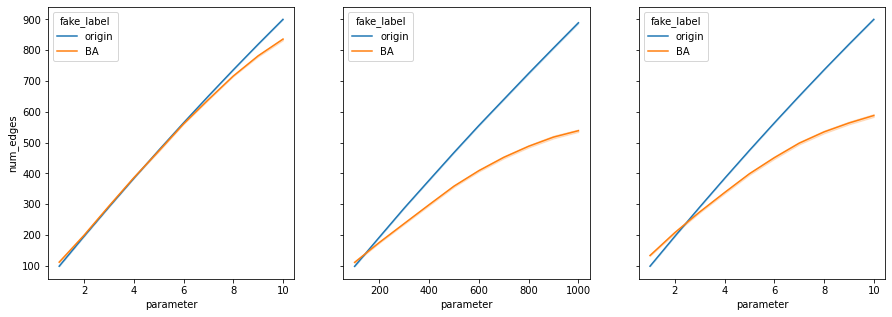

In [165]:
fig, axes = plt.subplots(1,3,figsize=(15,5), sharey=True)
for i,k in enumerate(["BA", "Attach", "Growth"]):
    q_plot(df,k,axes[i])

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


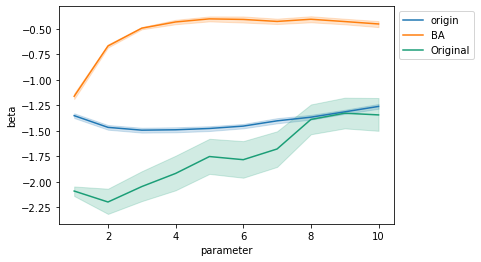

In [157]:
q_df = df.query("origin_label=='Growth' & fake_label in ['origin', 'BA']")
sns.lineplot(data=q_df, x="parameter", y="beta", hue="fake_label",legend=True)
q_df = df.query("origin_label=='BA' & fake_label=='origin'")
q_df.replace("origin", "Original", inplace=True)
sns.lineplot(data=q_df, x="parameter", y="beta", hue="fake_label", palette="Dark2", legend=True)
plt.legend(bbox_to_anchor = (1,1))

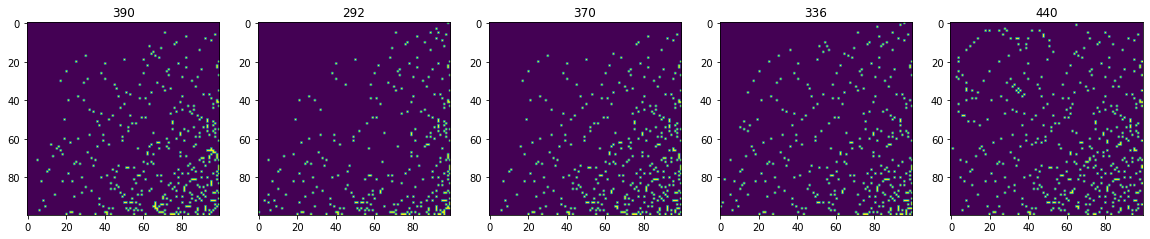

In [92]:
fig, axes = plt.subplots(1,5, figsize=(20,4))


# G = nx.barabasi_albert_graph(100,2, seed=2001)
G = no_growth(100, 200)

img = network_to_image(G, sort=True)
fake_tensor = img_transform(model, img, transform, device)

axes[0].imshow(img)
axes[0].set_title((np.array(img) > 1).sum())
for i in range(4):
    thres_array = (fake_tensor[i][0] + fake_tensor[i][0].T) > 1.
    axes[i+1].imshow(thres_array)
    axes[i+1].set_title(thres_array.sum().item())

In [103]:
c = Counter(dict(graph.degree()).values())

In [105]:
exponential_fitting(list(c.keys()), list(c.values()))

array([281.19243204,  -0.85373685])

In [116]:
print(result.fit_report())

[[Model]]
    Model(powerlaw)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 15
    # variables        = 2
    chi-square         = 21.9728064
    reduced chi-square = 1.69021587
    Akaike info crit   = 9.72633119
    Bayesian info crit = 11.1424316
[[Variables]]
    amplitude:  277.426480 +/- 23.8908499 (8.61%) (init = 51)
    exponent:  -2.42915744 +/- 0.10640486 (4.38%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, exponent) = -0.963


In [119]:
result.values

{'amplitude': 277.42647967070957, 'exponent': -2.4291574379851775}

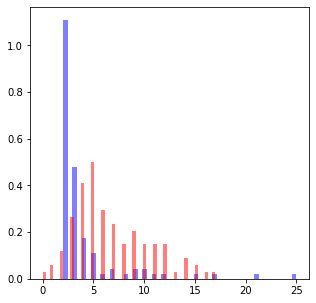

In [96]:
fig, axes  = plt.subplots(figsize=(5,5))
degree_hist(graph, axes, color="b", alpha=.5)
degree_hist(fake_graph, axes, color="r", alpha=.5)

In [18]:
dataloader_iter = iter(get_loader("../data/poisson"))

In [19]:
img, label = next(dataloader_iter)

In [24]:
label2onehot(label, 4)

tensor([[0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]])